# Приоритизация гипотез и анализ результатов А/В теста для интернет-магазина

Учебная работа. Самостоятельный исследовательский проект в рамках курса "Аналитик данных" Яндекс.Практикума.  
Спринт 8 "Принятие решений в бизнесе на основе данных"

## Общая информация о проекте
### Описание задания
Есть результаты оценки гипотез по параметрам Reach, Impact, Confidence, Effort, нужно рассчитать приоритизировать гипотезы методами ICE и RICE.  
Доступны результаты проведения А/В тестов, их нужно проанализировать и принять решение о наличии или отсутствии отличий или о продолжении теста.

###  Цель
Приоритизировать гипотезы и проанализировать результаты А/В теста. Принять решение по результатам А/В теста.

###  Данные
Архив объявлений о продаже квартир получен в виде файлов `hypothesis.csv`, `orders.csv`, `visitors.csv`.

###  Описание данных

**Структура файла `visits_log.csv`**  

 - `Hypothesis` — краткое описание гипотезы;
 - `Reach` — охват пользователей по 10-балльной шкале;
 - `Impact` — влияние на пользователей по 10-балльной шкале;
 - `Confidence` — уверенность в гипотезе по 10-балльной шкале;
 - `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 


**Структура файла `orders.csv`**  
 - `transactionId` — идентификатор заказа;
 - `visitorId` — идентификатор пользователя, совершившего заказ;
 - `date` — дата, когда был совершён заказ;
 - `revenue` — выручка заказа;
 - `group` — группа A/B-теста, в которую попал заказ.


**Структура файла `visitors.csv`**  
 - `date` — дата;
 - `group` — группа A/B-теста;
 - `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и обзор данных

Загружаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

Создаём библиотеку стилей:

In [2]:
class Color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Загружаем файлы с данными:

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Обзор и подготовка данных о гипотезах
Выведем первые 5 строк таблицы `hypothesis`:

In [4]:
display(hypothesis.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Проверим данные о столбцах:

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Названия столбцов содержат пробелы и заглавные буквы, поменяем регистр.

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Обзор и подготовка данных о заказах

Выведем первые пять строк таблицы `orders`:

In [7]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверим данные о столбцах:

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Проверяем таблицу на дубликаты:

Меняем тип данных в столбце `date`:

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
orders['date'].dtype

dtype('<M8[ns]')

In [10]:
print('Дублирующихся строк:', orders.duplicated().sum())

Дублирующихся строк: 0


Проверяем длительность временного интервала в столбце `date`:

In [11]:
print('Начало интервала:', orders['date'].min())
print('Конец интервала:', orders['date'].max())

Начало интервала: 2019-08-01 00:00:00
Конец интервала: 2019-08-31 00:00:00


A/B тест шёл ровно месяц, похоже на правду.  
Проверим корректность разделения пользователей на группы: проверим, есть ли пользователи, которые были отнесены к обеим группам:

In [12]:
ordersA = orders.query('group == "A"')
ordersB = orders.query('group == "B"')
display(any(ordersA['visitorId'].isin(ordersB['visitorId'])))

True

Чтобы посчитать количество пользователей, попавших в обе группы, объединим таблицы `ordersA` и `ordersB` методом `inner` и посчитаем уникальных пользователей.

In [13]:
confused_users = ordersA.merge(ordersB, on='visitorId')
print('Количество пользователей, попавших в обе группы:', confused_users['visitorId'].nunique())
print('Доля пользователей, попавших в обе группы: {:.2%}'.format(
    confused_users['visitorId'].nunique()/orders['visitorId'].nunique()))


Количество пользователей, попавших в обе группы: 58
Доля пользователей, попавших в обе группы: 5.63%


Пользователей, попавших в обе группы, около 6% (58 человек).


### Обзор и подготовка данных о посетителях

Выведем первые пять строк таблицы `visitors`:

In [14]:
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проверим данные о столбцах:

In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Меняем тип данных в столбце `date`

In [16]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors['date'].dtype

dtype('<M8[ns]')

Проверяем таблицу на дубликаты:

In [17]:
print('Дублирующихся строк:', visitors.duplicated().sum())

Дублирующихся строк: 0


Проверяем длительность временного интервала в столбце `date`:

In [18]:
print('Начало интервала:', visitors['date'].min())
print('Конец интервала:', visitors['date'].max())

Начало интервала: 2019-08-01 00:00:00
Конец интервала: 2019-08-31 00:00:00


Временной интервал совпадает с данными о заказах, выбросов нет.

### **Вывод**  
Таблицы проверены и подготовлены к работе.  
В данных найдены ошибки: некорректно разделены на группы пользователи. Есть пользователи, которые попали и в группу А, и в группу В. Нужно отправить багрепорт, а результаты данного А/В теста считать ненадёжными. 

## Анализ данных
### Приоритизация гипотез

Применим фреймворки ICE и RICE и сохраним их значения в новых столбцах таблицы `hypothesis`

In [19]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

pd.set_option('max_colwidth', 500)
display(hypothesis.round(1).sort_values(by='rice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


**ICE**  

|N|Гипотеза|ICE|Интерпретация ICE|Приоритет|Решение|
|:-|:---|:--|:---|:--|:--|
|8|Запустить акцию, дающую скидку на товар в день рождения	|16.2|С высокой степенью уверенности это изменение окажет сильное влияние на пользователей при среднем уровне усилий.|1|Провести A/B тестирование|
|0|Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей|13.3|С довольно высокой уверенностью относительно небольшими усилиями можно сильно повлиять на поведение пользователей|2|В очереди|
|7|Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок|11.2|С высокой степенью уверенности это изменение окажет достаточно сильное влияние на пользователей при среднем уровне усилий.|3|В очереди|
|6|Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию|8.0|Относительно высокая оценка `ICE` получена за счёт высокой степени уверенности. При этом предполагаемый эффект довольно небольшой, но и требуемые усилия тоже небольшие.|4|В очереди|
|2|Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа|7.0|Относительно высокая оценка `ICE` получена за счёт высокой степени уверенности. При этом предполагаемый эффект довольно небольшой, но и требуемые усилия тоже небольшие.|5|В очереди|
|1|Запустить собственную службу доставки, что сократит срок доставки заказов|2.0|Значения `ICE` низкие. Для реализации этой идеи требуются очень большие усилия, а влияние на пользоватлей и уверенность в результате - средние|6|Отклонить|
|5|Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов|1.3|С низкой степенью уверенности изменение окажет небольшое влияние на пользователей при небольших усилиях|7|Отклонить|
|3|Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар|1.1|Много усилий и небольшое влиение на пользователей при невысокой степени уверенности|8|Отклонить|
|4|Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей|1.0|`ICE` этой гипотезы самый низкий: минимальный эффект и минимальная уверенность, хотя и `Efforts` тоже минимальные.|9|Отклонить|

В соответствии с фрейворком ICE наиболее перспективными выглядят гипотезы 8, 0 и 7, а наименее перспективными - 1, 3, 4, 5.

**RICE**  
Посмотрим, что будет, если учесть охват пользователей:

|N|Гипотеза|RICE|Интерпретация RICE|Приоритет ICE|Приоритет RICE|Решение|
|:-|:--|:--|:--|:--|:--|:--|
|7|Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок|112|У этой гипотезы самый высокий охват при относительно высоких уверенности и влиянии и средних усилиях (форму подписки увидят все пользователи). Учёт охвата выводит гипотезу в приоритетную позицию.|3|1|Провести A/B тестирование|
|2|Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа|56|В рамках фрейворка `ICE` у этой гипотезы был средний приоритет, но за счёт большого охвата рейтинг `RICE` сильно выше. Предполагаемый эффект довольно небольшой, но и требуемые усилия тоже небольшие, а уверенность в результате достаточно высока.|5|2|В очереди|
|0|Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей|40|Охват относительно небольшой (изменение повлияет только на тех пользователей, которые будут привлечены при помощи двух новых каналов), но уровень влияения и уверенность очень хорошие|2|3|В очереди|
|6|Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию|40|Средний охват не повлиял на приоритет гипотезы|4|4|В очереди|
|8|Запустить акцию, дающую скидку на товар в день рождения	|16|Эта гипотеза выглядела самой перспективной с точки зрения фрейворка `ICE`, но у неё слишком маленький охват, так что её приоритет `RICE` значительно ниже|1|5|В очереди|
|3|Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар|9|У этого изменения высокий охват, но учитывая, что она требует большого количества усилий и оказывает незначительное влияние, рейтинг всё равно остаётся низким|8|6|Отклонить|
|1|Запустить собственную службу доставки, что сократит срок доставки заказов|4|Охват маленький, оценка рейтинга почти не изменилась|6|7|Отклонить|
|5|Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов|4|Охват маленький, оценка рейтинга почти не изменилась|7|8|Отклонить|
|4|Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей|3|Охват маленький, оценка рейтинга почти не изменилась|9|9|Отклонить|

В соответствии с фрейворком RICE на первый план вышла гипотеза 7 (добавить форму подписки), а рейтинг гипотезы 8 (подарок на день рождения) сильно снизился. В нашем случае охват гипотез очень разный и сильно влияет на ожидаемую эффективность изменений, так что лучше будет использовать для принятия решения фреймворк RICE.



#### **Вывод**  
В соответствии с фрейворком ICE наиболее перспективня гипотеза - №8 "Запустить акцию, дающую скидку на товар в день рождения". С высокой степенью уверенности при среднем уровне усилий она оказывает значительное влияние на пользователей. Однако у неё слишком маленький охват (только пользователи, у которых близко день рождения), поэтому в рамках фреймворка RICE она проигрывает.  
В соответствии с фрейворком RICE наиболее перспективная гипотеза - №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". У этой гипотезы очень высокий охват при относительно высоких уверенности и влиянии и средних усилиях (форму подписки увидят все пользователи). 

### Анализ A/B теста


Функция `cumulative_data_counter` для подготовки кумулятивных данных о посетителях, заказах и выручке. Принимает названия таблиц с посетителями и заказами и названия столбцов, возвращает таблицу с кумулятивными данными.

In [20]:
def cumulative_data_counter(data_visitors, group_v, date_v, visitors, data_oders, group_o, date_o, orders, revenue):
    """Функция для расчёта результатов A/B теста: проверяет значимость различий между группами,
    строит графики кумулятивных значений и график относительного различия, 
    возвращает таблицу с кумулятивными значениями parameter.
    Принимает аргументы:
    - data_visitors - название таблицы с данными о посетителях;
    - group_v - название столбца с данными о группе (А/В) в таблице с данными о посетителях;
    - date_v - название столбца с данными о дате посещения в таблице с данными о посетителях;
    - visitors - название столбца с данными о посетителях посещения в таблице с данными о посетителях;
    - data_oders - название таблицы с данными о заказах;
    - group_v - название столбца с данными о группе (А/В) в таблице с данными о заказах;
    - date_v - название столбца с данными о дате посещения в таблице с данными о заказах;
    - orders - название столбца с данными о заказах в таблице с данными о заказах;
    - revenue - название столбца с данными о выручке в таблице с данными о заказах
    
    Возвращает таблицу с данными о посетителях, заказах и выручке по дням и кумулятивными данными по дням."""
    
    """Округляем данные о датах до дней"""
    data_visitors[date_v] = data_visitors[date_v].astype('datetime64[D]')
    data_oders[date_o] = data_oders[date_o].astype('datetime64[D]')
    
    """Считаем кумулятивное количество посетителей по группам"""
    visitorsADaily = data_visitors[data_visitors[group_v] == 'A'][[date_v, visitors]]
    visitorsADaily.columns = ['date', 'visitorsPerDateA']
    visitorsACummulative = visitorsADaily.apply(
        lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
    visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

    visitorsBDaily = data_visitors[data_visitors[group_v] == 'B'][[date_v, visitors]]
    visitorsBDaily.columns = ['date', 'visitorsPerDateB']
    visitorsBCummulative = visitorsBDaily.apply(
        lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
    visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

    """Считаем кумулятивное количество заказов и прибыль по группам"""
    ordersADaily = (data_oders[data_oders[group_o] == 'A'].groupby(date_o, as_index=False)
                    .agg({orders: 'nunique', revenue: 'sum'}))
    ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
    ordersACummulative = ordersADaily.apply(
        lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
    ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

    ordersBDaily = (data_oders[data_oders[group_o] == 'B'].groupby(date_o, as_index=False)
                    .agg({orders: 'nunique', revenue: 'sum'}))
    ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
    ordersBCummulative = ordersBDaily.apply(
        lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])
    ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB']
    
    """Объединяем кумулятивные данные в таблицу"""
    data = (
        ordersADaily.merge(ordersBDaily, on='date', how='left')
        .merge(ordersACummulative, on='date', how='left')
        .merge(ordersBCummulative, on='date', how='left')
        .merge(visitorsADaily, on='date', how='left')
        .merge(visitorsBDaily, on='date', how='left')
        .merge(visitorsACummulative, on='date', how='left')
        .merge(visitorsBCummulative, on='date', how='left')
    )
    
    return data

In [21]:
cumulative_data = cumulative_data_counter(visitors, 'group', 'date', 'visitors', orders, 'group', 'date', 'transactionId', 'revenue')
display(cumulative_data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Функция `ab_plots` строит графики параметра по группам.

In [44]:
def ab_plots(data, sampleA, sampleB, date, name):
    """Функция для расчёта результатов A/B теста: проверяет значимость различий между группами,
    строит графики кумулятивных значений и график относительного различия.
    Принимает аргументы:
    - data - название таблицы с кумулятивными данными
    - sampleA - название столбца с кумулятивными данными группы А;
    - sampleB - название столбца с кумулятивными данными группы B;
    - date - название столбца с данными о дате посещения;
    - name - название параметра (для подписей на графиках)."""

    """Строим графики:
    ax_1 - кумулятивные значения параметра по группам,
    ax-2 - относительное изменение параметра"""
    fig = plt.figure(figsize=(13, 5))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    
    ax_1.plot(data[sampleA], label = 'группа А')
    ax_1.plot(data[sampleB], label = 'группа B')
    ax_1.set(title = 'Значения паметра \n"{}" по дням'.format(name), xlabel='время (дни)', ylabel=name)
    ax_1.legend()
    
    data['relative_parameter'] = data[sampleB] / data[sampleA] - 1
    
    ax_2.plot(data['relative_parameter'])
    plt.axhline(y=0, color='grey', linestyle='--')
    ax_2.set(title = 'Относительное изменение по дням \n значений параметра \n"{}"'.
             format(name), xlabel='время (дни)', ylabel='отношение параметра "{}" групп В/А'.format(name))
    plt.show()


Функция `differences` проверяет распределение на нормальность и считает статистическую значимость различий. 

In [23]:
def differences(sampleA, sampleB, alpha):
    """Функция для расчёта статистическую значимость различий распределения двух выборок. 
    Проверяет распределения на нормальность и рассчитывает для нормально распределённых данных
    T-критерий Стьюдента, а для не нормально распределённых данных - критерий Манна-Уитни.
    
    Принимает аргументы:
    - data - название таблицы с данными;
    - group - название столбца с данными о группе (А/В);
    - date - название столбца с данными о дате посещения;
    - visitors - название столбца с данными об посетителях;
    - orders - название столбца с данными о заказах;
    - alpha - уровень значимости для статистических критериев."""
    
    """Применяем критерий Манна-Уитни"""
    print(Color.BOLD + 'Считаем статистическую значимость различий. Критерий Манна-Уитни' + Color.END)
    print(Color.GREEN + 
          'H₀: распределение признака в первой выборке соответствует распределению признака во второй выборке \n' +
          Color.RED + 
          'H₁: распределение признака в первой выборке не соответствует распределению признака во второй выборке\n' + 
          Color.END)
    
    results = st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')

    if results.pvalue < alpha:
        print(Color.RED + 'mannwhitneyu p-value = {0:.3f}'.format(results.pvalue) + 
              '\nОтвергаем нулевую гипотезу: разница статистически значима' + Color.END)
    else:
        print(Color.GREEN + 'mannwhitneyu p-value = {0:.3f}'.format(results.pvalue) + 
              '\nНе получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя' + Color.END) 
  
 

    print("Относительное различие между группами: {:.0%}".format(sampleB.mean() / sampleA.mean() - 1))
    


Функции готовы к работе.

#### Анализ графиков кумулятивной выручки по сырым данным
Построим графики кумулятивной выручки и относительного изменения кумулятивной выручки при помощи функции `ab_plots`

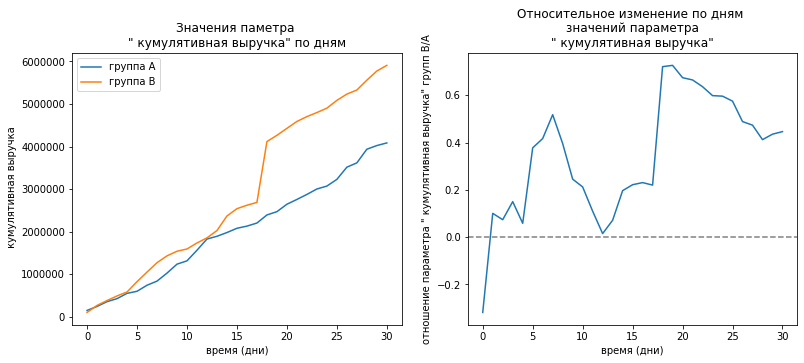

In [45]:
ab_plots(cumulative_data, 'revenueCummulativeA', 'revenueCummulativeB', 'date', 'кумулятивная выручка')

**Анализ графиков**  
График группы А равномерно растёт на протяжении всего теста, а график группы В резко подскакивает вверх в одну из дат. Критерий показывает статистически значимые различия, но, скорее всего, они появились за счёт выбросов (резкий скачок на графике).  
При этом график относительных изменений показывает преимущество группы B на всём протяжении теста.  

#### Анализ  графиков кумулятивного среднего чека по сырым данным

Рассчитаем средний чек по группам (разделим кумулятивную выручку по дня на кумулятивное количество заказов по дням).

In [25]:
cumulative_data['checkA'] = cumulative_data['revenueCummulativeA'] / cumulative_data['ordersCummulativeA']
cumulative_data['checkB'] = cumulative_data['revenueCummulativeB'] / cumulative_data['ordersCummulativeB']

Построим графики при помощи функции `ab_plots`.

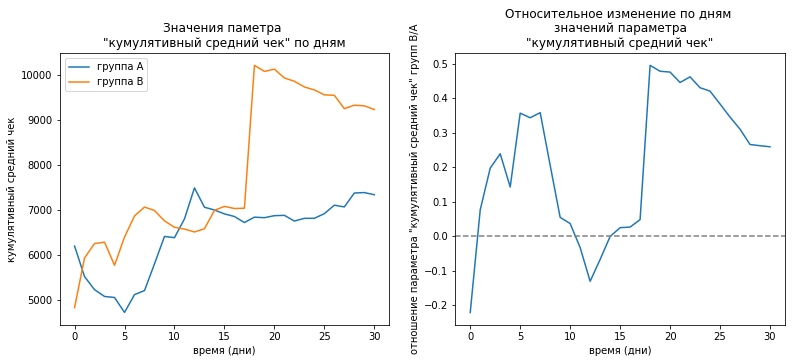

In [46]:
ab_plots(cumulative_data, 'checkA', 'checkB', 'date', 'кумулятивный средний чек')

На графиках кумулятивного среднего чека видны резкие скачки: на 8-12 день в группе А и на 18 день в группе В. В данных есть выбросы.  
График относительного изменения среднего чека колеблется. На большем протяжении графика преимущество у группы В, но на 1-12 день оно теряется (вероятно, в группе А была сделана какая-то особо крупная покупка). Посмотрим, что будет видно на очищенных данных.

#### Анализ выбросов

**Количество заказов на пользователя**  
Построим scatterplot для количества заказов по пользователям.  
Сгруппируем данные по пользователям:

In [27]:
orders_visitors = orders.groupby('visitorId', as_index=False)['transactionId'].count()
orders_visitors = orders_visitors.rename(columns={'transactionId':'orders'})

display(orders_visitors.head())

,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


Построим scatterplot:

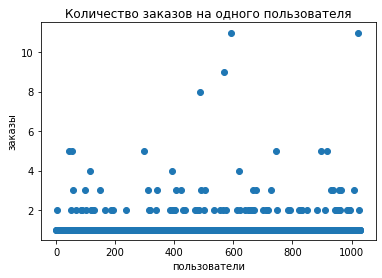

In [28]:
x_values = pd.Series(range(0,len(orders_visitors)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_values, orders_visitors['orders'])
ax.set_title('Количество заказов на одного пользователя')
ax.set_ylabel('заказы')
ax.set_xlabel('пользователи')
plt.show()

Большинство пользователей делали заказ только один раз. Довольно много пользователей с 2-3 заказами, и определённо есть выбросы: пользователи с 8-10 заказами.  
Посчитаем 95-й и 99-й перцентиль:

In [29]:
print(np.percentile(orders_visitors['orders'], [95, 99])) 

[2. 4.]


5% пользователей оформляли больше двух заказов и 1% пользователей заказывали больше 4 раз. Выберем верхней границей числа заказов 3.

**Стоимость заказов**
Построим scatterplot для стоимости заказов:

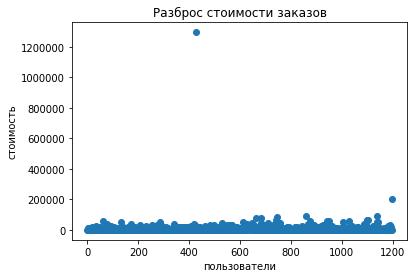

In [30]:
x_values = pd.Series(range(0,len(orders)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_values, orders['revenue'])
ax.set_title('Разброс стоимости заказов')
ax.set_ylabel('стоимость')
ax.set_xlabel('пользователи')
plt.show()

В стоимости заказов выбросов гораздо меньше, но один из них - очень большой. Вероятно, именно его мы и видели на графиках.  
Большинство пользователей делает покупки на сумму до 10т. Но есть покупка в 20т и покупка больше 120т. Её, безусловно, надо отсеивать.  
Посчитаем 95-й и 99-й перцентиль:

In [31]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% посетителей покупают на сумму больше 28т и не более 1% - на сумму больше 58233. Выберем границей для отсева сумму в 30т.

#### Отсев данных об аномальных пользователях
Сохраним id аномальных пользователей в список `abnormalUsers`.

In [32]:
usersWithManyOrders = orders_visitors[orders_visitors['orders'] > 3]['visitorId']
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:', len(abnormalUsers))

Количество аномальных пользователей: 61


Подготовим таблицу с очищенными кумулятивными данными `cumulative_data_filtered`.

In [33]:
orders_filtered = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]
cumulative_data_filtered = cumulative_data_counter(
    visitors, 'group', 'date', 'visitors', orders_filtered, 'group', 'date', 'transactionId', 'revenue')
display(cumulative_data_filtered.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,19,78258,23,142779,19,78258,719,713,719,713
1,2019-08-02,20,93822,21,93234,43,236601,40,171492,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,67,349074,56,285740,507,509,1845,1803
3,2019-08-04,13,66415,15,74421,80,415489,71,360161,717,770,2562,2573
4,2019-08-05,25,124218,22,90008,105,539707,93,450169,756,707,3318,3280


Данные очищены от выбросов.

#### Анализ конверсии по сырым данным

Добавим в таблицу `cumulative_data` расчёт конверсии по группам.

In [34]:
cumulative_data['conversionA'] = cumulative_data['ordersCummulativeA'] / cumulative_data['visitorsCummulativeA']
cumulative_data['conversionB'] = cumulative_data['ordersCummulativeB'] / cumulative_data['visitorsCummulativeB']

Подготовим выборки к проверке критерием Манна-Уитни. Посчитаем число заказов для каждого пользователя.

In [35]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

В переменных `sampleA` и `sampleB` объединим количество заказов для пользователей, совершавших покупки с нулями для пользователей, которые не совершали покупки.

In [36]:
sampleA = pd.concat(
    [ordersByUsersA['orders'], pd.Series(0, index=np.arange(
        cumulative_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(0, index=np.arange(
        cumulative_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Передадим переменные `sampleA` и `sampleB` функции `differences` и посчитаем значимость различий. Построим графики кумулятивной конверсии по группам при помощи функции ab_plots.

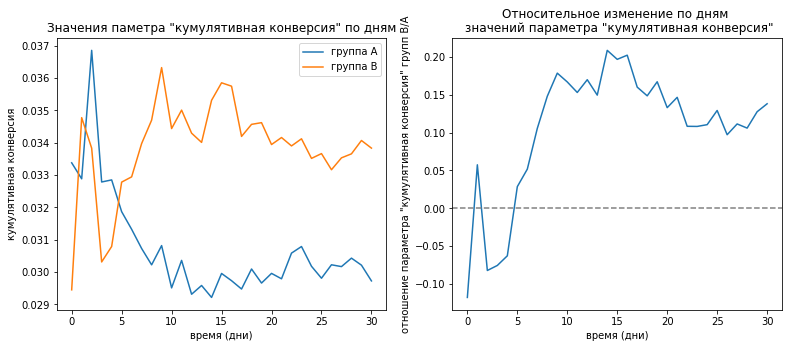

Считаем статистическую значимость различий. Критерий Манна-Уитни
H₀: распределение признака в первой выборке соответствует распределению признака во второй выборке 
H₁: распределение признака в первой выборке не соответствует распределению признака во второй выборке

mannwhitneyu p-value = 0.017
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие между группами: 14%


In [37]:
ab_plots(cumulative_data, 'conversionA', 'conversionB', 'date', 'кумулятивная конверсия')
differences(sampleA, sampleB, 0.05)

    
__Анализ графиков__   
    
Графики конверсии "зубчатые", "скачущие" в обеих группах, но значения держатся в рамках небольшого диапазона, и конверсия в группе B выше, чем в группе А.   
График относительного изменения конверсии колеблется лишь в самом начале, а затем принимает стабильные положительные значения.  

__Статистическая значимость различий__
    
    
Отвергаем нулевую гипотезу о равенстве распределений выборок с уровнем значимости p-value = 0.017.  
Относительное различие между группами: 14% (конверсия в группе В на 14% лучше, чем в группе А).


#### Анализ среднего чека по сырым данным

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию `differences` данные о выручке с заказов.  

In [38]:
differences(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], 0.05)

Считаем статистическую значимость различий. Критерий Манна-Уитни
H₀: распределение признака в первой выборке соответствует распределению признака во второй выборке 
H₁: распределение признака в первой выборке не соответствует распределению признака во второй выборке

mannwhitneyu p-value = 0.729
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительное различие между группами: 26%


__Статистическая значимость различий__
       
Относительное различие между группами большое (26%), но уровень значимости значительно больше 0.05, что не даёт нам возможности отвергнуть нулевую гипотезу. Причин считать, что в среднем чеке по группам есть различия, нет (p-value > 0.7).
Однако по графику кумулятивного среднего чека мы знаем, что в данных есть выбросы. Возможно, удастся получить статистически значимые различия по очищенным данным.                                                                                           

#### Анализ конверсии по очищенным данным

Рассчитаем конверсию по очищенным данным.

In [39]:
cumulative_data_filtered['conversionA'] = cumulative_data_filtered[
    'ordersCummulativeA'] / cumulative_data_filtered['visitorsCummulativeA']
cumulative_data_filtered['conversionB'] = cumulative_data_filtered[
    'ordersCummulativeB'] / cumulative_data_filtered['visitorsCummulativeB']

Подготовим выборки к проверке критерием Манна-Уитни. Посчитаем число заказов для каждого пользователя по очищенным данным.

In [40]:
ordersByUsersA_filtered = (
    orders_filtered[orders_filtered['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersA_filtered.columns = ['visitorId', 'orders']

ordersByUsersB_filtered = (
    orders_filtered[orders_filtered['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersB_filtered.columns = ['visitorId', 'orders'] 

В переменных `sampleA` и `sampleB` объединим количество заказов для пользователей, совершавших покупки с нулями для пользователей, которые не совершали покупки.

In [41]:
sampleA_filtered = pd.concat(
    [ordersByUsersA_filtered['orders'], pd.Series(0, index=np.arange(
        cumulative_data_filtered['visitorsPerDateA'].sum() - 
        len(ordersByUsersA_filtered['orders'])), name='orders')],axis=0)

sampleB_filtered = pd.concat(
    [ordersByUsersB_filtered['orders'], pd.Series(0, index=np.arange(
        cumulative_data_filtered['visitorsPerDateB'].sum() - 
        len(ordersByUsersB_filtered['orders'])), name='orders')],axis=0)

Передадим переменные `sampleA` и `sampleB` функции `differences` и посчитаем значимость различий. Построим графики кумулятивной конверсии по группам при помощи функции ab_plots.

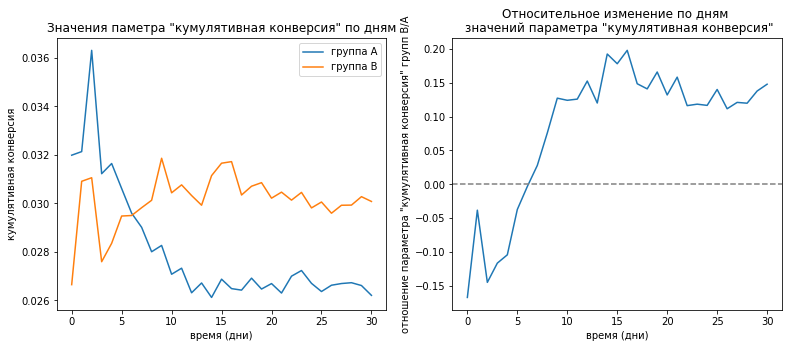

Считаем статистическую значимость различий. Критерий Манна-Уитни
H₀: распределение признака в первой выборке соответствует распределению признака во второй выборке 
H₁: распределение признака в первой выборке не соответствует распределению признака во второй выборке

mannwhitneyu p-value = 0.017
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие между группами: 14%


In [42]:
ab_plots(cumulative_data_filtered, 'conversionA', 'conversionB', 'date', 'кумулятивная конверсия')
differences(sampleA, sampleB, 0.05)

__Анализ графиков__   
    
Как и на сырых данных, графики конверсии "зубчатые", "скачущие" в обеих группах, но значения держатся в рамках небольшого диапазона, и конверсия в группе B выше, чем в группе А.   
График относительного изменения конверсии колеблется лишь в самом начале, а затем принимает стабильные положительные значения.  

__Статистическая значимость различий__
    
Отвергаем нулевую гипотезу о равенстве распределений выборок с уровнем значимости p-value = 0.017.  
Относительное различие между группами: 14% (конверсия в группе В на 14% лучше, чем в группе А).  
В результате очистки данных от выбросов вывод для конверсии пользователей практически не изменился. 
    
__Решение__
    
Графики всё ещё "зубчатые", но уже примерно понятно, в каких пределах значения установятся, при этом конверсия группы В стабильно выше конверсии группы А. Различия между группами значимые. Тест можно останавливать, зафиксировав победу группы В.    

#### Анализ среднего чека по очищенным данным

Построим графики кумулятивного среднего чека по очищенным данным при помощи функции `ab_plots` и передадим их функции `differences`.  

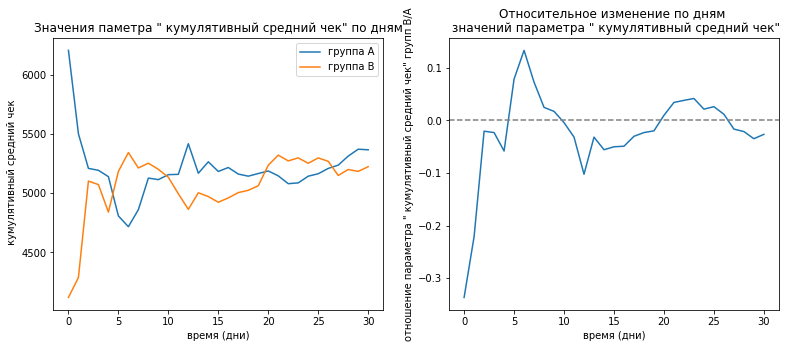

Считаем статистическую значимость различий. Критерий Манна-Уитни
H₀: распределение признака в первой выборке соответствует распределению признака во второй выборке 
H₁: распределение признака в первой выборке не соответствует распределению признака во второй выборке

mannwhitneyu p-value = 0.815
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительное различие между группами: -3%


In [43]:
cumulative_data_filtered['checkA'] = cumulative_data_filtered[
    'revenueCummulativeA'] / cumulative_data_filtered['ordersCummulativeA']
cumulative_data_filtered['checkB'] = cumulative_data_filtered[
    'revenueCummulativeB'] / cumulative_data_filtered['ordersCummulativeB']

ab_plots(cumulative_data_filtered, 'checkA', 'checkB', 'date', ' кумулятивный средний чек')
differences(orders_filtered[orders_filtered['group']=='A']['revenue'], 
            orders_filtered[orders_filtered['group']=='B']['revenue'], 0.05)

__Анализ графиков__   
    
Значения кумулятивного среднего чека колеблются в обеих группах, а график относительного изменения кумулятивного среднего чека колеблется вокруг нуля. Нет оснований говорить о преимуществе какой-либо из групп.  
    
__Статистическая значимость различий__

На очищенных данных отвергнуть нулевую гипотезу тоже не получилось, вывод о различии сделать нельзя (p-value > 0.8). В отличие от сырых данных относительное различие между группами совсем небольшое (-3%), вероятно, на сырых данных это различие создавалось именно выбросами. 
    
__Решение__
    
Графики кумулятивного среднего чека колебляются, а различия между группами - небольшие и не значимые. Не оснований ожидать, что при продолжении теста группа В обгонит группу А по размеру среднего чека. Можно останавливать тест, зафиксировав отсутствие различий между группами по размеру среднего чека.


#### **Вывод**

Анализ данных о выручке и среднем чеке показал наличие в данных выбросов.  
Анализ данных о среднем чеке не показал различий между группами (по сырым данным p-value > 0.7, по очищенным данным p-value > 0.8).  
Анализ данных о выручке показал различия между группами и по сырым, и по очищенным данным (p-value = 0.017).  
По обоим параметрам тест можно останавливать, зафиксировав отсутствие различий между группами по среднему чеку и победу группы В по конверсии.

## Общие выводы

### Краткий обзор проведённой работы

Данные подготовлены к работе. Данные проверены на наличие пропусков и дубликатов. Изменён тип данных столбцов в тех случаях, где он не соответствовал цели.  

Проведена приоритизация гипотез при помощи фреймворков `ICE` и `RICE`.

Проанализированы результаты А/В теста. Построены графики кумулятивных значений по группам и относительного изменения кумулятивных значений для параметров:
 - выручка;
 - средний чек;
 - конверсия.
 
Рассчитана статистическая значимость различий по сырым и очищенным данным для параметров:
 - средний чек;
 - конверсия.

Принято решение по результатам А/В теста и сформулированы выводы.

### Выводы 
----
1. **Корректность проведения A/B теста**  
    При проведении А/В теста была нарушена процедура: значительная часть пользователей (16%) попала в обе группы. Результаты теста нельзя в полной мере считать надёжными.
-----
2. **Приоритизация гипотез**  
    В соответствии с фрейворком ICE наиболее перспективня гипотеза - №8 "Запустить акцию, дающую скидку на товар в день рождения". С высокой степенью уверенности при среднем уровне усилий она оказывает значительное влияние на пользователей. Однако у неё слишком маленький охват (только пользователи, у которых близко день рождения), поэтому в рамках фреймворка RICE она проигрывает.  
    В соответствии с фрейворком RICE наиболее перспективная гипотеза - №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". У этой гипотезы очень высокий охват при относительно высоких уверенности и влиянии и средних усилиях (форму подписки увидят все пользователи).  
    Для проведения А/В теста лучше выбрать гипотезу №7:  
    ***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок***  
----
3. **Анализ результатов А/В теста**  
    Анализ данных кумулятивной выручки и кумулятивного среднего чека показал наличие в данных выбросов.  
    
    Анализ данным по среднему чеку не показал различий между группами (по сырым данным p-value > 0.7, по очищенным данным p-value > 0.8). Графики кумулятивного среднего чека в обеих группах колеблются (и для сырых, и для очищенных данных). Тест можно останавливать, зафиксировав отсутствие различий между группами по размеру среднего чека.
    
    Анализ данных выручки показал различия между группами (и по сырым, и по очищенным данным p-value = 0.017). Графики стабилизировались в пределах небольшого диапазона. Тест можно останавливать, зафиксировав победу группы B. 
----    
4. **Решение**    
    По обоим параметрам тест можно останавливать, зафиксировав отсутствие различий между группами по среднему чеку и победу группы В по конверсии.